# Load Models

In [1]:
import tensorflow as tf
import os

# Directory where models are saved
models_directory = 'trained_models'

# Get list of model directories or files in the 'trained_models' folder
model_paths = [os.path.join(models_directory, model_name) for model_name in os.listdir(models_directory)]

# Initialize an empty list to store the loaded models
loaded_models = []

# Load each model
for model_path in model_paths:
    # Check if the model is in SavedModel format by looking for the 'saved_model.pb' file
    if os.path.isdir(model_path) and 'saved_model.pb' in os.listdir(model_path):
        model = tf.keras.models.load_model(model_path)
        loaded_models.append(model)
    # Check if the model is in HDF5 format by looking for the '.h5' extension
    elif model_path.endswith('.h5'):
        model = tf.keras.models.load_model(model_path)
        loaded_models.append(model)

print(f"Loaded {len(loaded_models)} models from '{models_directory}' directory.")

Loaded 5 models from 'trained_models' directory.


# Load Images

In [2]:
import os
import random
import numpy as np
import tensorflow as tf

def load_random_images_from_each_class(base_dir, image_size=(128, 128), num_samples=30):
    class_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
    selected_images = []
    selected_labels = []
    label_to_idx = {label: idx for idx, label in enumerate(class_folders)}
    
    for label in class_folders:
        image_files = [f for f in os.listdir(os.path.join(base_dir, label)) if f.endswith(('.png', '.jpg', '.jpeg'))]
        sampled_image_files = random.sample(image_files, num_samples)
        
        for image_file in sampled_image_files:
            image_path = os.path.join(base_dir, label, image_file)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            selected_images.append(image_array)
            selected_labels.append(label_to_idx[label])
    
    return np.array(selected_images), np.array(selected_labels)

test_images, test_labels = load_random_images_from_each_class('./data_sorted/testing')

# Make Predictions

In [3]:
# List to store arrays of predictions (the softmax output) for each model
all_predictions = []

for model in loaded_models:
    # Predict to get raw scores
    predictions = model.predict(test_images)
    
    # Append the array of softmax scores to all_predictions
    all_predictions.append(predictions)


5/5 [==============================] - 1s 109ms/step


# Model Analysis

5/5 [==============================] - 1s 110ms/step
Classification report for Model 1
              precision    recall  f1-score   support

     Arborio       0.00      0.00      0.00        30
     Basmati       0.52      1.00      0.68        30
      Ipsala       0.49      1.00      0.66        30
     Jasmine       1.00      0.03      0.06        30
   Karacadag       1.00      0.57      0.72        30

    accuracy                           0.52       150
   macro avg       0.60      0.52      0.43       150
weighted avg       0.60      0.52      0.43       150

5/5 [==============================] - 1s 121ms/step
Classification report for Model 2
              precision    recall  f1-score   support

     Arborio       0.96      0.80      0.87        30
     Basmati       0.70      1.00      0.82        30
      Ipsala       1.00      1.00      1.00        30
     Jasmine       1.00      0.50      0.67        30
   Karacadag       0.81      1.00      0.90        30

    accurac

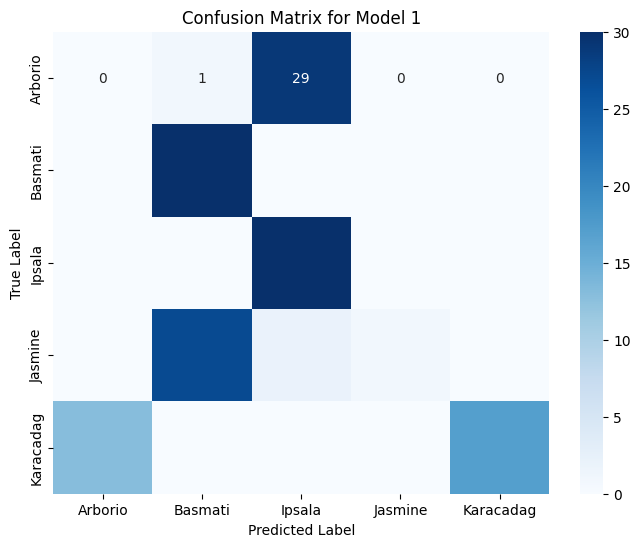

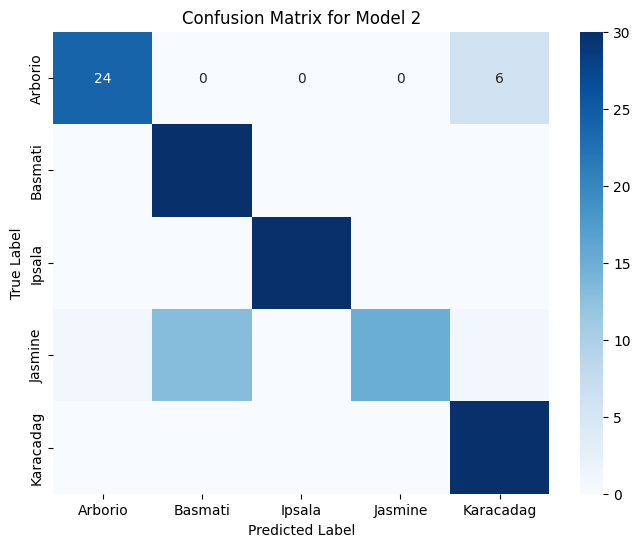

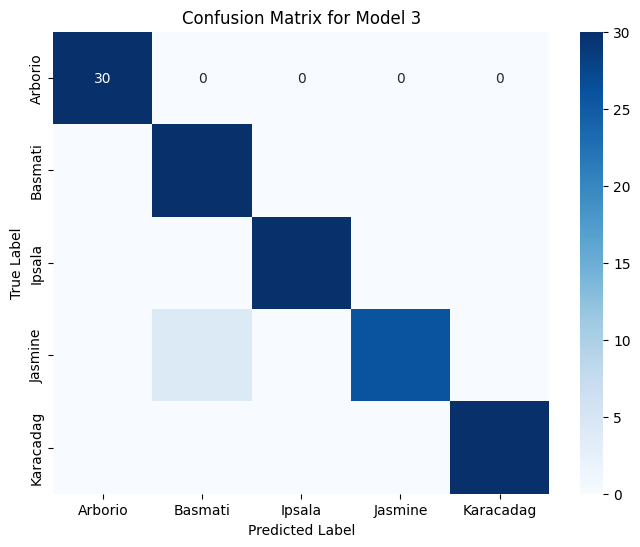

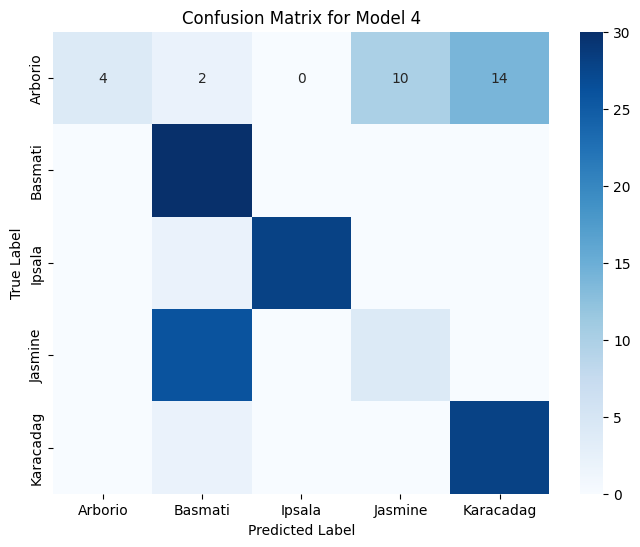

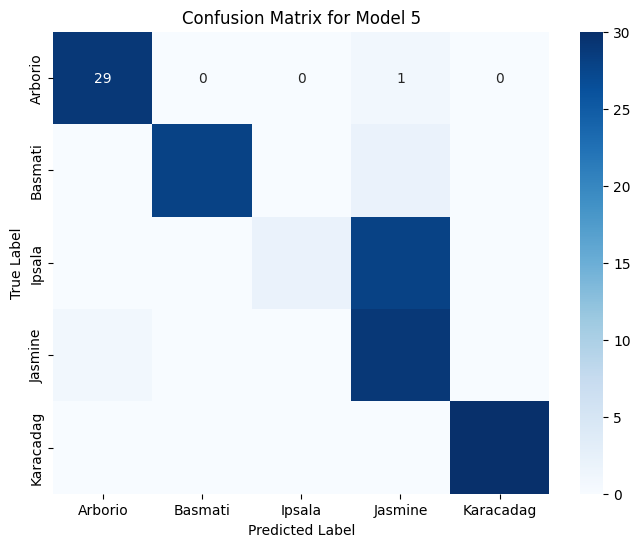

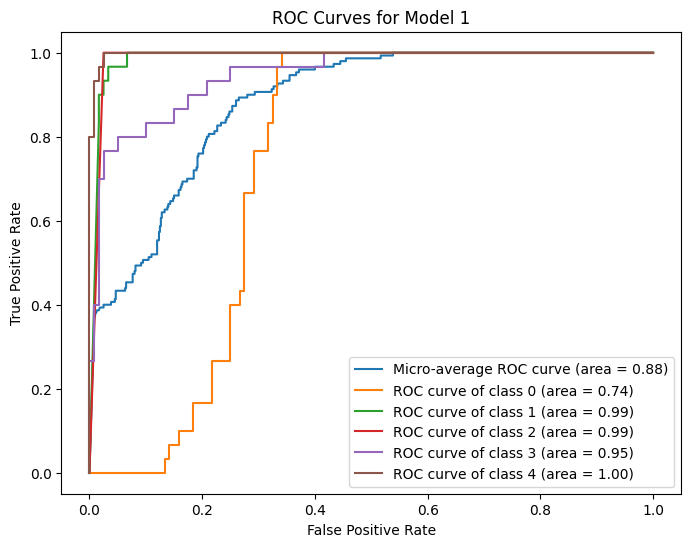

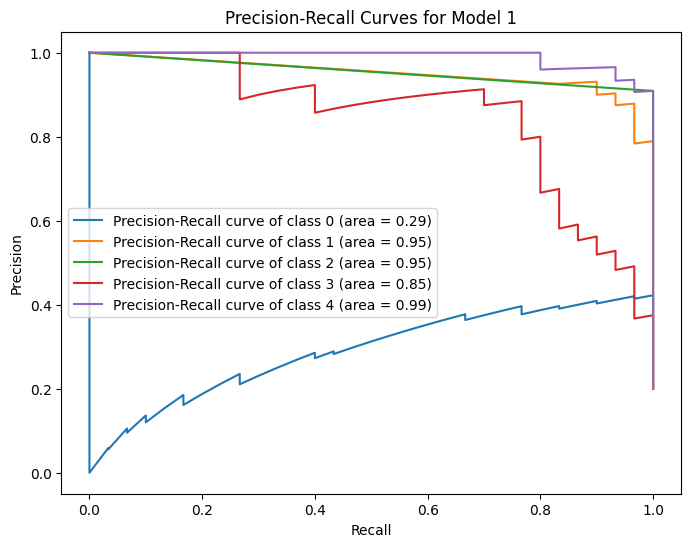

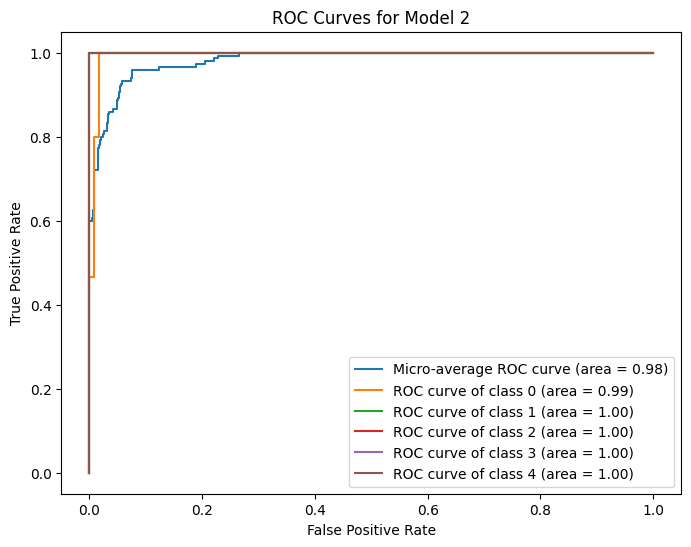

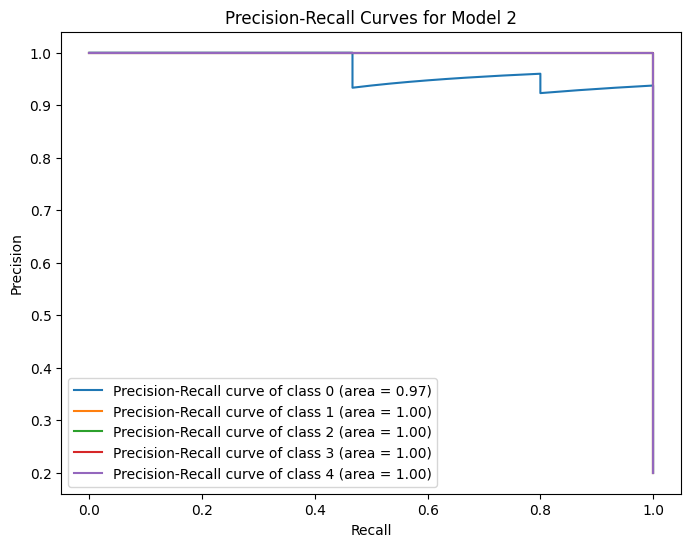

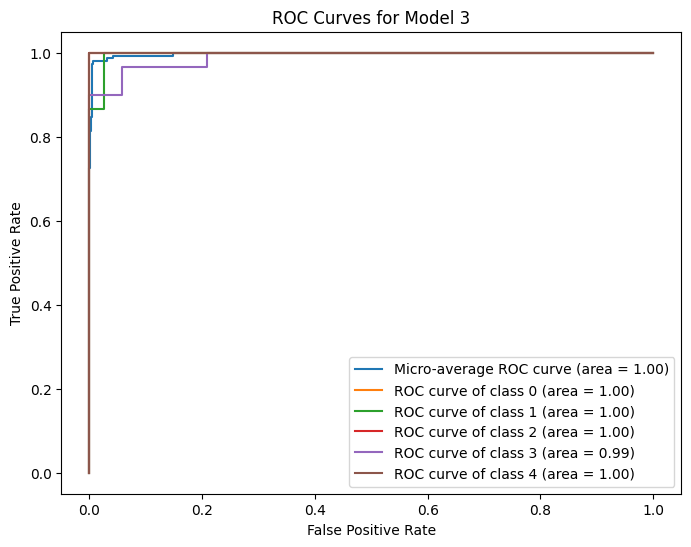

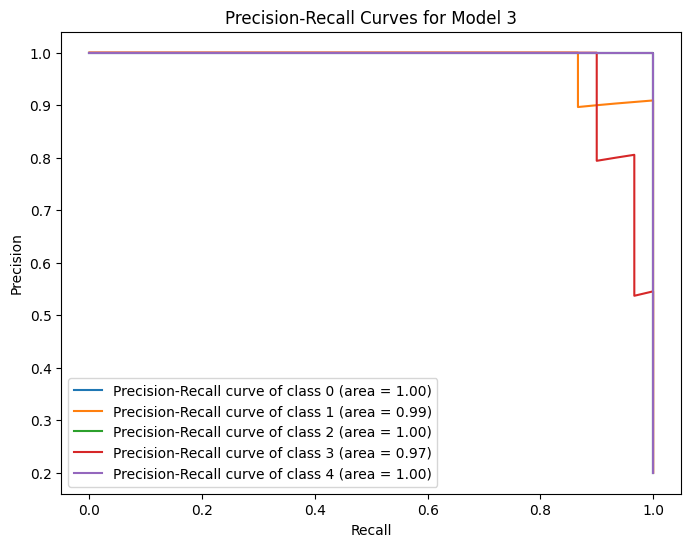

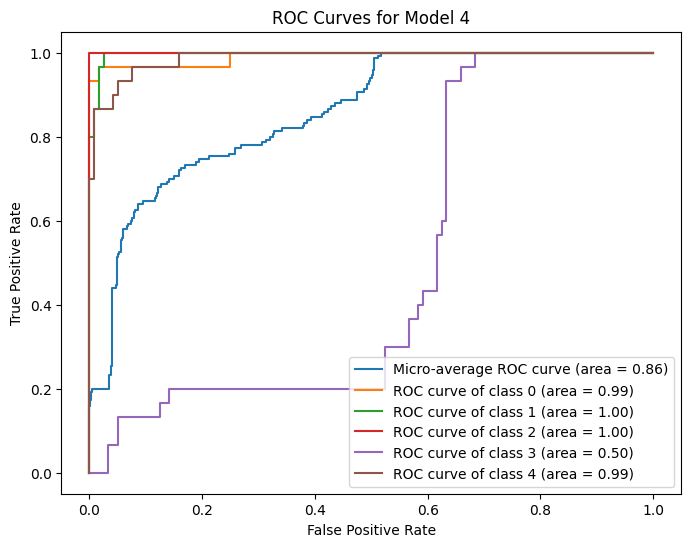

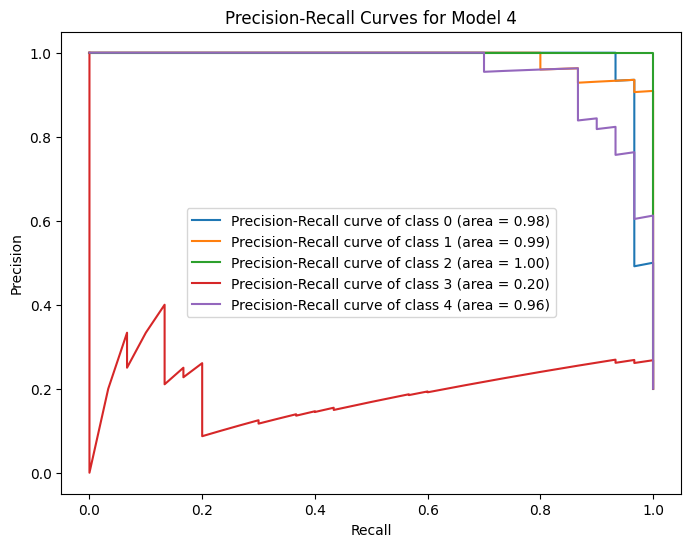

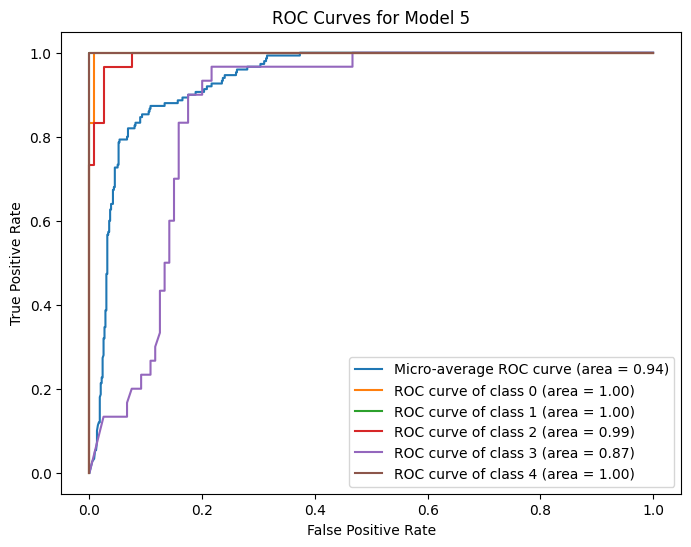

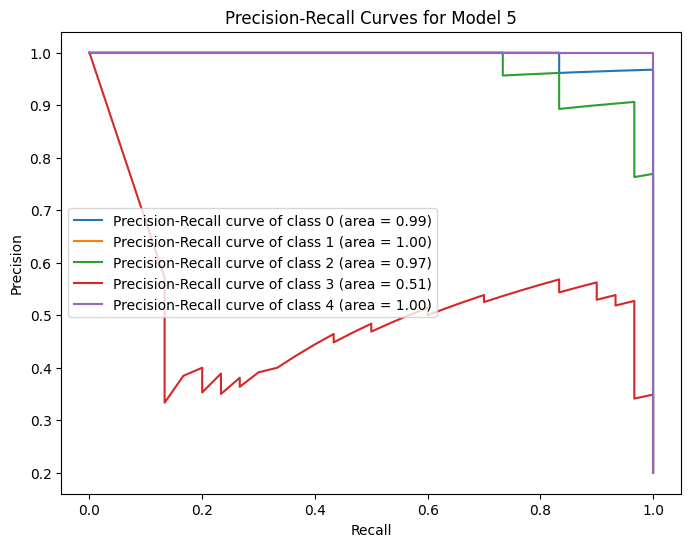

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
import seaborn as sns

class_names = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']

def plot_confusion_matrix(cm, labels, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)

def plot_roc_curves(y_true, y_score, n_classes, title='ROC Curves'):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curves(y_true, y_score, n_classes, title='Precision-Recall Curves'):
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision[i] = auc(recall[i], precision[i])

    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0} (area = {1:0.2f})'.format(i, average_precision[i]))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="best")
    plt.show()

def evaluate_models(models, images, true_labels, class_names):
    y_true = label_binarize(true_labels, classes=range(len(class_names)))
    all_predictions = []

    for model_index, model in enumerate(models):
        # Predict the probabilities for each class
        predictions = model.predict(images)
        all_predictions.append(predictions)

        # Convert probabilities to predicted classes
        predicted_classes = np.argmax(predictions, axis=1)
        cm = confusion_matrix(true_labels, predicted_classes)

        # Plot confusion matrix
        plot_confusion_matrix(cm, class_names, title=f'Confusion Matrix for Model {model_index + 1}')

        # Print classification report
        print(f"Classification report for Model {model_index + 1}")
        print(classification_report(true_labels, predicted_classes, target_names=class_names))

    # Plot ROC and Precision-Recall curves for all models
    for model_index, predictions in enumerate(all_predictions):
        plot_roc_curves(y_true, predictions, len(class_names), title=f'ROC Curves for Model {model_index + 1}')
        plot_precision_recall_curves(y_true, predictions, len(class_names), title=f'Precision-Recall Curves for Model {model_index + 1}')

# Assuming loaded_models is a list of trained models and test_images, test_labels are loaded
evaluate_models(loaded_models, test_images, test_labels, class_names)


5/5 [==============================] - 1s 111ms/step


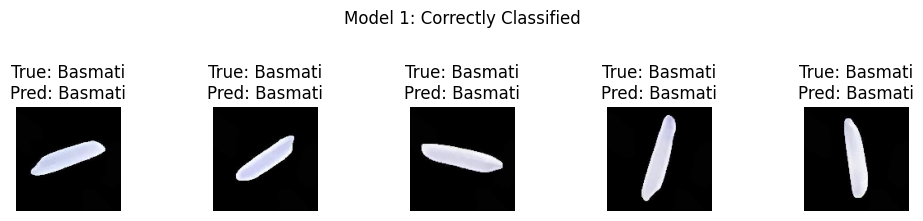

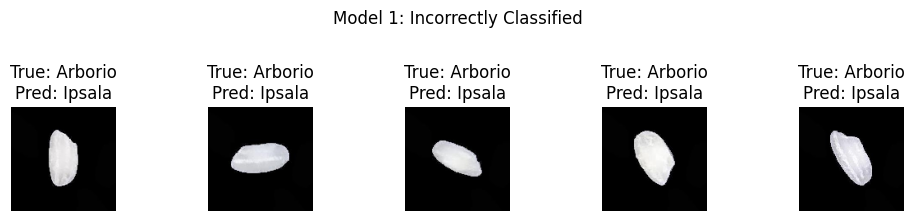

5/5 [==============================] - 1s 111ms/step


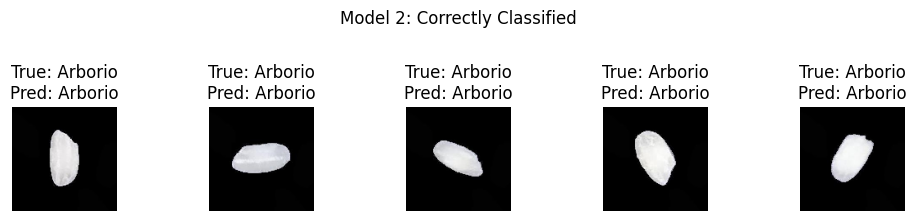

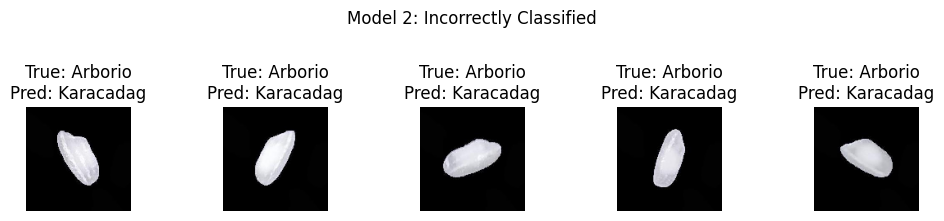

5/5 [==============================] - 1s 108ms/step


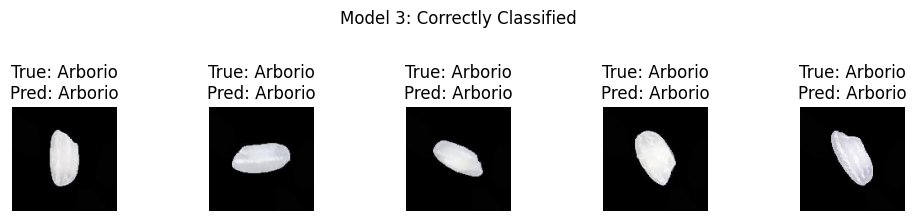

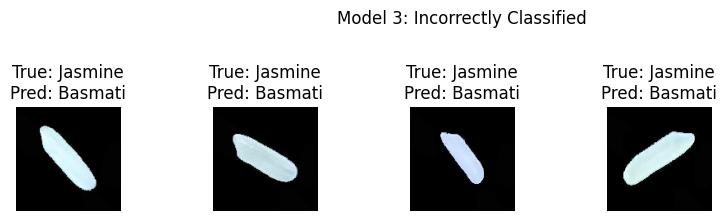

5/5 [==============================] - 1s 111ms/step


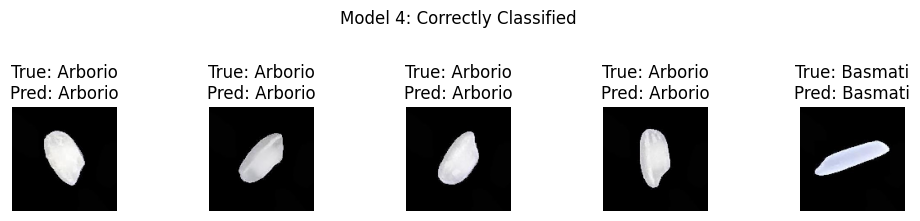

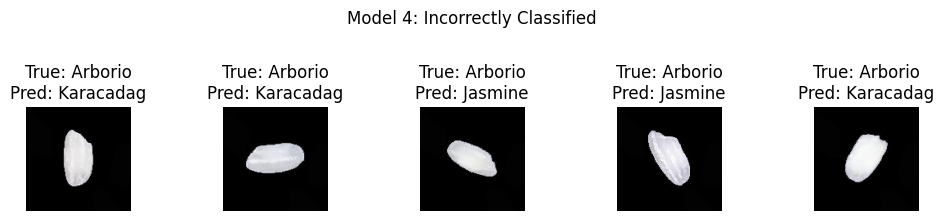

5/5 [==============================] - 1s 109ms/step


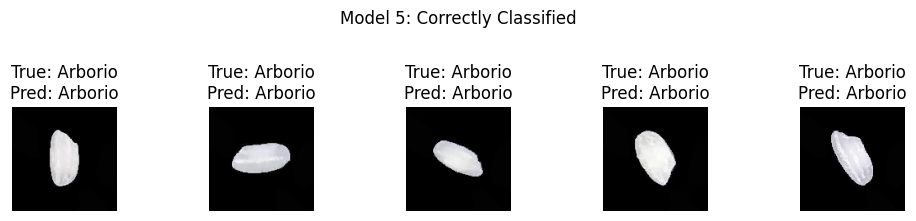

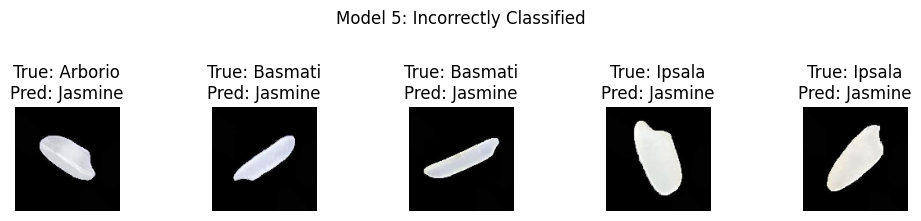

In [6]:
import matplotlib.pyplot as plt

# Function to display correctly and incorrectly classified images for each model
def display_classification_examples(models, test_images, test_labels, class_names):
    for model_index, model in enumerate(models):
        # Predict the classes for the test set
        predicted_classes = np.argmax(model.predict(test_images), axis=1)
        
        # Find the indices of the correct and incorrect predictions
        correct_indices = np.where(predicted_classes == test_labels)[0]
        incorrect_indices = np.where(predicted_classes != test_labels)[0]
        
        # Select 5 correctly classified images and 5 incorrectly classified images
        correct_sample_indices = correct_indices[:5]
        incorrect_sample_indices = incorrect_indices[:5]
        
        # Display correctly classified images
        plt.figure(figsize=(10, 2))
        for i, index in enumerate(correct_sample_indices, 1):
            plt.subplot(1, 5, i)
            plt.imshow(test_images[index].astype('uint8'))
            plt.title(f'True: {class_names[test_labels[index]]}\nPred: {class_names[predicted_classes[index]]}')
            plt.axis('off')
        plt.suptitle(f'Model {model_index + 1}: Correctly Classified', y=1.08)  # Adjust the sup title position
        plt.tight_layout()  # Adjust the layout
        plt.show()
        
        # Display incorrectly classified images
        plt.figure(figsize=(10, 2))
        for i, index in enumerate(incorrect_sample_indices, 1):
            plt.subplot(1, 5, i)
            plt.imshow(test_images[index].astype('uint8'))
            plt.title(f'True: {class_names[test_labels[index]]}\nPred: {class_names[predicted_classes[index]]}')
            plt.axis('off')
        plt.suptitle(f'Model {model_index + 1}: Incorrectly Classified', y=1.08)  # Adjust the sup title position
        plt.tight_layout()  # Adjust the layout
        plt.show()
        
display_classification_examples(loaded_models, test_images, test_labels, class_names)


# Ensembles

In [10]:
# Implemented with softmax

ensemble_134_predictions = np.zeros_like(loaded_models[0].predict(test_images))

# Get predictions from models 1, 3, and 4 and average them
for model_idx in [1, 3, 4]:
    ensemble_134_predictions += loaded_models[model_idx].predict(test_images)

ensemble_134_predictions /= 3
ensemble_134_predicted_classes = np.argmax(ensemble_134_predictions, axis=1)

ensemble_024_predictions = np.zeros_like(loaded_models[0].predict(test_images))

# Get predictions from models 0, 2, and 4 and average them
for model_idx in [0, 2, 4]:
    ensemble_024_predictions += loaded_models[model_idx].predict(test_images)

ensemble_024_predictions /= 3
ensemble_024_predicted_classes = np.argmax(ensemble_024_predictions, axis=1)

5/5 [==============================] - 1s 104ms/step


In [11]:
# Classification Report for the Ensemble 1-3-4
print("Ensemble 1-3-4 Model Performance:")
print(classification_report(test_labels, ensemble_134_predicted_classes))

# Classification Report for the Ensemble 0-2-4
print("Ensemble 0-2-4 Model Performance:")
print(classification_report(test_labels, ensemble_024_predicted_classes))


Ensemble 1-3-4 Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       0.91      1.00      0.95        30
           2       1.00      1.00      1.00        30
           3       1.00      0.87      0.93        30
           4       0.97      1.00      0.98        30

    accuracy                           0.97       150
   macro avg       0.98      0.97      0.97       150
weighted avg       0.98      0.97      0.97       150

Ensemble 0-2-4 Model Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        30
           1       0.83      1.00      0.91        30
           2       1.00      1.00      1.00        30
           3       1.00      0.80      0.89        30
           4       1.00      0.97      0.98        30

    accuracy                           0.95       150
   macro avg       0.96      0.95      0.95       150
weighted 